In [1]:
import nltk
import pandas as pd
import numpy
import csv
import string
from nltk.corpus import stopwords
import pickle
stop_words = set(stopwords.words("English"))

# Loading Data

In [2]:
data = pd.read_csv("London_hotel_reviews.csv", encoding='latin1')

In [3]:
data1 = data.copy()

#  Cleaning the data to make it more easy to process

# Convert text to lower case

In [4]:
data1["Property Name"] = data["Property Name"].apply(lambda x: x.lower() if type(x) == str else x)
data1["Review Title"] = data["Review Title"].apply(lambda x: x.lower() if type(x) == str else x)
data1["Review Text"] = data["Review Text"].apply(lambda x: x.lower() if type(x) == str else x)
data1["Location Of The Reviewer"] = data["Location Of The Reviewer"].apply(lambda x: x.lower() if type(x) == str else x)

# Tokenize Text

In [5]:
from nltk.tokenize import word_tokenize as wd
def tokenize(line):
    word = wd(line)
    return word

In [6]:
data1["Property Name"] = data1["Property Name"].apply(lambda x: tokenize(x) if type(x) == str else x)
data1["Review Title"] = data1["Review Title"].apply(lambda x: tokenize(x) if type(x) == str else x)
data1["Review Text"] = data1["Review Text"].apply(lambda x: tokenize(x) if type(x) == str else x)
data1["Location Of The Reviewer"] = data1["Location Of The Reviewer"].apply(lambda x: tokenize(x) if type(x) == str else x)

In [7]:
data2 = data1.copy()

#data2.head(10)

# Further Cleaning: Removing Punctuation and stopwords

In [8]:
def remove_punctuation(column_name):
    all_sentences = []
    for i in data2.index:
        my_sentence = []
        custom_stopwords=["a","'s","..."," 's", "'m ","i ",",","\t"]
        pr=data2.loc[i, column_name]
        if(type(pr) != float):
            for item in pr:
                if(item not in string.punctuation):
                    if (item not in stop_words):
                        if(item not in custom_stopwords):
                            my_sentence.append(item)
        final_sentence = " ".join(my_sentence)
        all_sentences.append(final_sentence)
        
    return all_sentences


In [9]:
all_sentence = remove_punctuation("Review Text")
data2["Review Text"] = all_sentence
all_sentence = remove_punctuation("Property Name")
data2["Property Name"] = all_sentence
all_sentence = remove_punctuation("Review Title")
data2["Review Title"] = all_sentence
all_sentence = remove_punctuation("Location Of The Reviewer")
data2["Location Of The Reviewer"] = all_sentence

# Saving cleaned data as csv

In [10]:
data2.to_csv(path_or_buf="./clean_data.csv")

# Loading Data Processed by SentiStrength

In [11]:
data2["Review Text"].to_csv(path_or_buf="./review.txt", sep="\t", index=None,header=False)

In [12]:
data_sentiment = pd.read_csv("Review_with_sentiment.csv")

# Calculating Overall Sentiment & storing in separate dataframe

In [13]:
def calculate_overall_sentiment(df):
    overall_sentiment = []
    for i in df.index:
        positive = int(df["Positive"][i])
        negative = int(df["Negative"][i])
        overall = positive + negative
        overall_sentiment.append(overall)
    return overall_sentiment
        

In [14]:
data2["Positive"] = data_sentiment["Positive"]
data2["Negative"] = data_sentiment["Negative"]

In [15]:
df_correlation = data2.drop(labels="Property Name",axis="columns")
df_correlation = df_correlation.drop(labels="Review Text",axis="columns")
df_correlation = df_correlation.drop(labels="Location Of The Reviewer",axis="columns")
df_correlation = df_correlation.drop(labels="Date Of Review",axis="columns")
df_correlation = df_correlation.drop(labels="Review Title",axis="columns")
overall_sentiment = calculate_overall_sentiment(df_correlation)
df_correlation["Overall Sentimet"] = overall_sentiment

# Calculating Pearson Correlation Coefficient

In [16]:
df_correlation.corr(method='pearson')

,Review Rating,Positive,Negative,Overall Sentimet
Review Rating,1.000000,0.256865,0.330641,0.417469
Positive,0.256865,1.000000,-0.021256,0.728032
Negative,0.330641,-0.021256,1.000000,0.669913
Overall Sentimet,0.417469,0.728032,0.669913,1.000000


# Calculating First order statistics (Mean) of reviews grouped by hotels

In [17]:
data2.groupby(['Property Name']).mean()

,Review Rating,Positive,Negative
Property Name,,,
45 park lane dorchester collection,4.752577,3.211340,-1.706186
apex london wall hotel,4.694785,3.058957,-1.610884
bulgari hotel london,4.710359,3.019027,-1.608879
city view hotel,1.611111,2.500000,-2.555556
corinthia hotel london,4.789007,3.219858,-1.731206
dorchester,4.624419,3.135465,-1.825581
hartley hotel,1.568182,2.045455,-2.727273
hotel xenia autograph collection,4.523622,3.042651,-1.595144
lanesborough,4.808642,3.074074,-1.583333


# Calculating Second order statistics (Standard Deviation) of reviews grouped by hotels

In [18]:
data2.groupby(['Property Name']).std()

,Review Rating,Positive,Negative
Property Name,,,
45 park lane dorchester collection,0.558141,0.911456,0.827796
apex london wall hotel,0.579282,0.901284,0.766275
bulgari hotel london,0.700059,0.932952,0.831889
city view hotel,0.777544,0.785905,1.149026
corinthia hotel london,0.634656,0.870405,0.827913
dorchester,0.810552,0.886666,0.870188
hartley hotel,0.899554,0.913835,1.207797
hotel xenia autograph collection,0.751514,0.947827,0.752847
lanesborough,0.619937,0.967302,0.784427


In [19]:
data2.loc[data2['Property Name'] == 'newham hotel'].head(10)

,Property Name,Review Rating,Review Title,Review Text,Location Of The Reviewer,Date Of Review,Positive,Negative
285,newham hotel,4,great stay budget,hotel great place stay budget rooms clean comf...,manchester united kingdom,5/26/2018,3,-2
302,newham hotel,2,great,great dirty poorly maintained judging breakfas...,,8/19/2018,3,-2
396,newham hotel,1,daughters 18th birthday,overall room acceptable basic clean however he...,,1/20/2016,3,-2
660,newham hotel,1,nightmares,reviews exaggerate got man arguing loudly man ...,indianapolis indiana,7/15/2012,1,-3
810,newham hotel,2,ok young foreign visitors base,partner booked www.booking.com convenient over...,birmingham united kingdom,4/7/2015,4,-2
830,newham hotel,3,okay safe clean,booking worried clean location .. location tax...,isle man united kingdom,7/27/2009,2,-4
883,newham hotel,1,worth £55 night,extremely low quality hotel worth £55 paid nig...,rochdale united kingdom,5/4/2015,2,-4
1220,newham hotel,1,cancelled booking 1645 day arrival four months...,booked hotel family member march july 1645 cal...,north east wales uk,7/5/2015,1,-2
1374,newham hotel,1,slightly better sleeping street emphasise `` s...,terrible terrible terrible unless 're going wa...,wollongong australia,11/21/2012,2,-5
1453,newham hotel,2,lazy decor bad maintenance miserable staff,£75 per night cheap east end 1 hooks toilet ha...,dewsbury united kingdom,8/21/2016,4,-3


In [39]:
data2.loc[data2['Property Name'] == 'z hotel'].head(50)

,Property Name,Review Rating,Review Title,Review Text,Location Of The Reviewer,Date Of Review,Positive,Negative
23,z hotel,5,excellent rapport qualité prix,15 mn à pied 5 en bus passage fréquent de la s...,paris france,1/5/2016,2,-2
105,z hotel,2,minimo indispensabile,un letto un bagno un tetto punto non bisogna a...,treviso italy,11/21/2015,1,-1
323,z hotel,3,ok hotel forhold til prisen,hvis man vælger et hotel som dette så skal man...,risskov denmark,6/4/2013,1,-1
516,z hotel,2,filthy unhygienic,hotel good value money filthy unhygienic worki...,london united kingdom,2/16/2016,2,-2
635,z hotel,1,blanker horror,dieses haus müsste geschlossen werden haare am...,dortmund germany,7/28/2014,1,-2
790,z hotel,2,interesting,friendly bedding clean situated good location ...,kingston-upon-hull united kingdom,8/30/2016,2,-1
927,z hotel,2,klassisk engelsk stil trevligt område,klassiskt engelskstil slitet otätafönster helt...,kalmar county sweden,4/23/2016,1,-1
1027,z hotel,4,seriously £49.99 twin room expect,want impress wife stay somewhere really nice p...,stafford united kingdom,5/26/2018,3,-2
1141,z hotel,1,non lo consiglio,ho alloggiato questo hotel e la camera era spa...,,4/16/2015,1,-1
1193,z hotel,3,bedre enn forventet,helt greit hotell som fungerer helt fint som s...,london united kingdom,8/1/2015,1,-1


In [38]:
data2.loc[data2['Property Name'] == 'mandarin oriental hyde park london'].head(50)

,Property Name,Review Rating,Review Title,Review Text,Location Of The Reviewer,Date Of Review,Positive,Negative
11,mandarin oriental hyde park london,4,good hotel needs touch-up improved layout entr...,location next park close harvey nic harrods me...,oslo norway,2/17/2014,3,-2
17,mandarin oriental hyde park london,5,beautiful,mandarin london lives five star rating deserve...,los angeles california,8/31/2014,4,-1
31,mandarin oriental hyde park london,5,exceptional service great location brilliant food,mandarin oriental hyde park pretty much everyt...,england,5/17/2015,3,-1
42,mandarin oriental hyde park london,5,amazing 5 star hotel,came back marvelous stay mandarin oriental hyd...,sao paulo sp,11/19/2015,4,-1
63,mandarin oriental hyde park london,5,best whole world,best hotel whole world first itme london 3 yea...,sgrocks,2/15/2012,3,-1
73,mandarin oriental hyde park london,5,great location heart knightsbridge,beautiful old hotel heart london facing sloane...,montgomery alabama,5/30/2014,3,-1
84,mandarin oriental hyde park london,4,confortavel e belo,hotel de alto padrao com localizacao fantastic...,sao bernardo campo sp,4/5/2015,3,-1
127,mandarin oriental hyde park london,5,special afternoon tea,40th birthday gorgeous wife treated afternoon ...,twickenham,3/18/2015,3,-1
128,mandarin oriental hyde park london,5,great location,perfectly located opposite harvey nichols arou...,southampton united kingdom,5/21/2016,3,-2
135,mandarin oriental hyde park london,5,mandarin oriental london,although refurbishment amazing stay staff welc...,,11/28/2017,3,-1


# Generate Histogram

In [22]:
import matplotlib
%matplotlib inline

array([[<AxesSubplot:title={'center':'Review Rating'}>]], dtype=object)

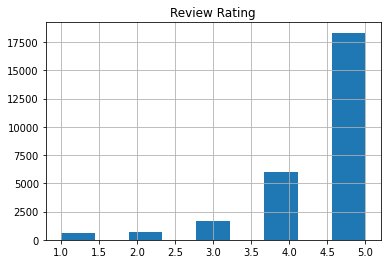

In [23]:
#data2.plot.hist(by='Review Rating', bins=15)
data2.hist(column='Review Rating', bins=9)


# Selecting STD threshold at 95% for ambigous class

In [41]:
max_values = data2.groupby(['Property Name']).std().max()
max_std = max_values["Review Rating"]
std_threshold = max_std * 0.75 
print(std_threshold)

1.0927929486281602
